<a href="https://colab.research.google.com/github/Vacayy/generalization-cifar10/blob/main/1_3_Generalization_Cifar10_3rd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cifar10 - Deep learning techniques

2차 시도 수정사항:
- train_model 함수의 정확도 계산 시 model.eval() 추가
  - 훈련 모드 - Dropout이 비활성화되어 모든 뉴런이 활성 상태로 유지됩니다
- 훈련 중단을 대비하여 체크포인트 로직 추가

3차 시도 수정사항:
- Leaky ReLU와 Sigmoid 성능 비교

4차 시도 수정사항:
- Dropout 적용 테스트
  - 활성화 함수: Leaky ReLU | 비용 함수: CrossEntropyLoss | Optimizer: Adam | Dropout
  - Trainset과 Testset의 정확도 차이 (Epoch 50 기준)
    - Dropout 적용 전: 34.7%p
    - Dropout 적용 후: 24.0%p

# 1. SGD와 Adam 성능 비교

## [MY CODE] Load trainset, testset

In [16]:
# import
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch import nn
from torch.optim import SGD
from matplotlib import pyplot as plt

# Load trainset, testset
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


## [MY CODE] Create a Dataloader for each of trainset and testset

In [17]:
# Create a Dataloader for each of trainset and testset
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

torch.Size([3, 32, 32]) 6
3 32 32


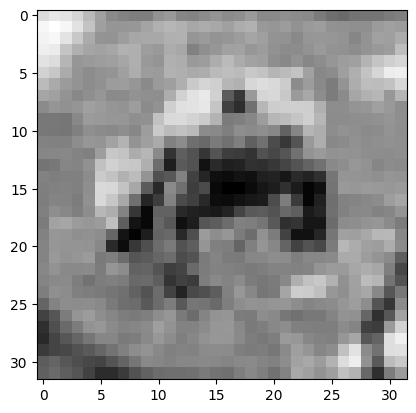

In [18]:
image, label = trainset[0]
print(image.shape, label) # torch.Size([3, 32, 32]) -> 3 channel(R, G, B), 32x32 image
print(len(image), len(image[0]), len(image[0][0])) # 3 32 32
plt.imshow(image[0], cmap='Greys')

## [MY CODE] Model class - Leaky ReLU

In [19]:
class Model_LeakyReLU(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # Set Output Dimension to Number of Classes (10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) # nn.CrossEntropyLoss takes logits as input, so no activation is applied to the last layer

    return x

## [MY CODE] Model, Optimizer getter 함수

In [20]:
def get_leaky_relu_model(input_dim, n_dim):
  model = Model_LeakyReLU(input_dim, n_dim).to('cuda')
  return model

def get_optimizer_sgd(model, lr):
  optimizer = SGD(model.parameters(), lr=lr)
  return optimizer

def get_optimizer_adam(model, lr):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  return optimizer

## [MY CODE] Accuracy 계산 함수



In [21]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  model.eval()
  with torch.no_grad():
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      preds = model(inputs)
      preds = torch.argmax(preds, dim=-1)

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

  model.train()
  return acc / cnt

## [MY CODE] 훈련 체크포인트 함수

학습 한번에 드는 리소스가 크기 때문에,
학습이 예기치않게 중단되는 경우를 대비하여 torch.save와 torch.load 를 활용하였습니다.

In [22]:
# 체크포인트 저장 함수
def save_checkpoint(epoch, model, optimizer, train_accuracies, test_accuracies, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at {filepath}")

# 체크포인트 로드 함수
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_accuracies = checkpoint['train_accuracies']
    test_accuracies = checkpoint['test_accuracies']

    print(f"Checkpoint loaded: Resuming from epoch {start_epoch}")
    return start_epoch, train_accuracies, test_accuracies


## [MY CODE] 모델 훈련 함수

In [23]:
def train_model(model, trainloader, testloader, optimizer, loss_function, n_epochs, checkpoint_path):
    train_accuracies = []
    test_accuracies = []
    start_epoch = 0

    # 체크포인트가 존재하면 불러오기
    try:
        start_epoch, train_accuracies, test_accuracies = load_checkpoint(checkpoint_path, model, optimizer)
    except (FileNotFoundError, KeyError, RuntimeError) as e:
        print(f"Checkpoint load failed: {e}. Starting from scratch.")

    # 학습 Loop
    for epoch in range(start_epoch, n_epochs):
        total_loss = 0.

        for data in trainloader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = loss_function(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # 정확도 계산
        train_accuracy = accuracy(model, trainloader)
        test_accuracy = accuracy(model, testloader)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1:3d} | Loss: {total_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")

        # 매 epoch 마다 체크포인트 저장
        save_checkpoint(epoch, model, optimizer, train_accuracies, test_accuracies, checkpoint_path)

    return train_accuracies, test_accuracies


## [MY CODE] 모델 훈련 - SGD optimizer

In [9]:
leaky_relu_model_1 = get_leaky_relu_model(32 * 32 * 3, 1024) # 새로운 Model instance 생성
sgd_optimizer = get_optimizer_sgd(leaky_relu_model_1, 0.001) # SGD optimizer 생성 (lr == 0.001)
cross_entropy_loss = nn.CrossEntropyLoss() # Loss function 생성 (CrossEntropyLoss)
sgd_checkpoint_path = './checkpoint_sgd.pth' # 체크포인트 파일 경로

sgd_train_accuracies, sgd_test_accuracies = train_model(leaky_relu_model_1, trainloader, testloader, sgd_optimizer, cross_entropy_loss, 50, sgd_checkpoint_path) # 학습 실행

<ipython-input-7-d3b0badec0bd>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


Checkpoint load failed: [Errno 2] No such file or directory: './checkpoint_sgd.pth'. Starting from scratch.
Epoch   1 | Loss: 450.6676 | Train Accuracy: 0.1390 | Test Accuracy: 0.1414
Checkpoint saved at ./checkpoint_sgd.pth
Epoch   2 | Loss: 448.4682 | Train Accuracy: 0.1215 | Test Accuracy: 0.1238
Checkpoint saved at ./checkpoint_sgd.pth
Epoch   3 | Loss: 446.6036 | Train Accuracy: 0.1333 | Test Accuracy: 0.1367
Checkpoint saved at ./checkpoint_sgd.pth
Epoch   4 | Loss: 444.8343 | Train Accuracy: 0.1489 | Test Accuracy: 0.1507
Checkpoint saved at ./checkpoint_sgd.pth
Epoch   5 | Loss: 443.0216 | Train Accuracy: 0.1719 | Test Accuracy: 0.1716
Checkpoint saved at ./checkpoint_sgd.pth
Epoch   6 | Loss: 441.1093 | Train Accuracy: 0.1894 | Test Accuracy: 0.1892
Checkpoint saved at ./checkpoint_sgd.pth
Epoch   7 | Loss: 439.0357 | Train Accuracy: 0.2023 | Test Accuracy: 0.2017
Checkpoint saved at ./checkpoint_sgd.pth
Epoch   8 | Loss: 436.7757 | Train Accuracy: 0.2129 | Test Accuracy: 0.21

## [MY CODE] 모델 훈련 - Adam optimizer

In [10]:
leaky_relu_model_2 = get_leaky_relu_model(32 * 32 * 3, 1024) # Create a new Model instance
adam_optimizer = get_optimizer_adam(leaky_relu_model_2, 0.001) # Create Adam optimizer with learning rate 0.001
cross_entropy_loss = nn.CrossEntropyLoss() # Create loss func (CrossEntropyLoss)
adam_checkpoint_path = './checkpoint_adam.pth' # 체크포인트 파일 경로

adam_train_accuracies, adam_test_accuracies = train_model(leaky_relu_model_2, trainloader, testloader, adam_optimizer, cross_entropy_loss, 50, adam_checkpoint_path) # 학습 실행

Checkpoint load failed: [Errno 2] No such file or directory: './checkpoint_adam.pth'. Starting from scratch.


<ipython-input-7-d3b0badec0bd>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


Epoch   1 | Loss: 370.4838 | Train Accuracy: 0.3776 | Test Accuracy: 0.3762
Checkpoint saved at ./checkpoint_adam.pth
Epoch   2 | Loss: 326.8102 | Train Accuracy: 0.4278 | Test Accuracy: 0.4301
Checkpoint saved at ./checkpoint_adam.pth
Epoch   3 | Loss: 309.4104 | Train Accuracy: 0.4334 | Test Accuracy: 0.4216
Checkpoint saved at ./checkpoint_adam.pth
Epoch   4 | Loss: 295.9362 | Train Accuracy: 0.4710 | Test Accuracy: 0.4553
Checkpoint saved at ./checkpoint_adam.pth
Epoch   5 | Loss: 286.6253 | Train Accuracy: 0.4906 | Test Accuracy: 0.4726
Checkpoint saved at ./checkpoint_adam.pth
Epoch   6 | Loss: 277.7181 | Train Accuracy: 0.4828 | Test Accuracy: 0.4627
Checkpoint saved at ./checkpoint_adam.pth
Epoch   7 | Loss: 269.6961 | Train Accuracy: 0.5066 | Test Accuracy: 0.4791
Checkpoint saved at ./checkpoint_adam.pth
Epoch   8 | Loss: 263.2722 | Train Accuracy: 0.5244 | Test Accuracy: 0.4971
Checkpoint saved at ./checkpoint_adam.pth
Epoch   9 | Loss: 257.7294 | Train Accuracy: 0.5448 | Te

## [MY CODE] Monitoring results

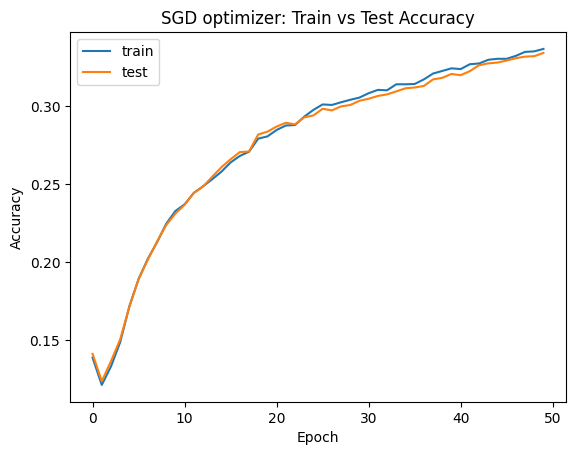

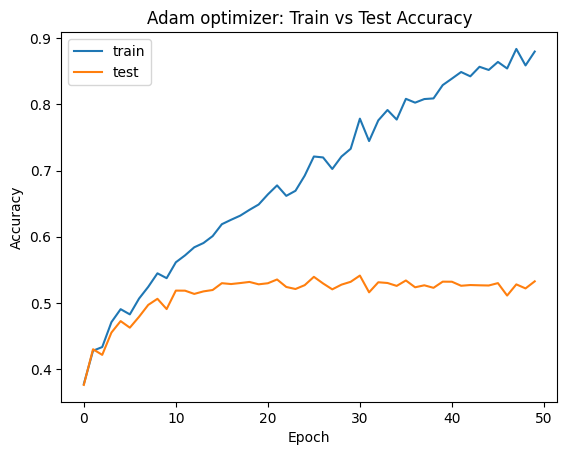

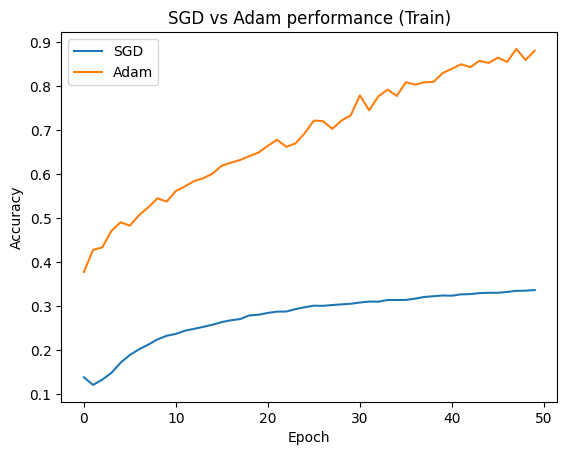

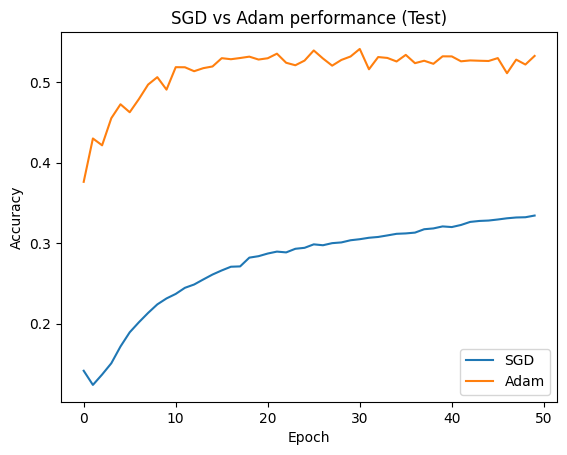

In [11]:

def plot_acc(title, first_metric, second_metric, label1, label2):
  x = np.arange(len(first_metric))

  plt.plot(x, first_metric, label=label1)
  plt.plot(x, second_metric, label=label2)
  plt.title(f'{title}')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

plot_acc('SGD optimizer: Train vs Test Accuracy', sgd_train_accuracies, sgd_test_accuracies, 'train', 'test')
plot_acc('Adam optimizer: Train vs Test Accuracy', adam_train_accuracies, adam_test_accuracies, 'train', 'test')
plot_acc('SGD vs Adam performance (Train)', sgd_train_accuracies, adam_train_accuracies, 'SGD', 'Adam')
plot_acc('SGD vs Adam performance (Test)', sgd_test_accuracies, adam_test_accuracies, 'SGD', 'Adam')

# 2. Leaky ReLU와 Sigmoid 성능 비교

## [MY CODE] Model class - Sigmoid

In [12]:
class Model_Sigmoid(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) # 여전히 loss function은 CrossEntropyLoss 이므로 마지막에 활성화 적용 X

    return x

## [MY CODE] Sigmoid 기반 모델 getter 함수 정의

In [13]:
def get_sigmoid_model(input_dim, n_dim):
  model = Model_Sigmoid(input_dim, n_dim).to('cuda')
  return model

## [MY CODE] Sigmoid 기반 모델 훈련 실행

In [14]:
sigmoid_model = get_sigmoid_model(32 * 32 * 3, 1024) # 새로운 Model instance 생성
adam_optimizer_sigmoid = get_optimizer_adam(sigmoid_model, 0.001) # SGD optimizer 생성 (lr == 0.001)
cross_entropy_loss = nn.CrossEntropyLoss() # Loss function 생성 (CrossEntropyLoss)
sigmoid_checkpoint_path = './checkpoint_sigmoid_adam.pth' # 체크포인트 파일 경로

sigmoid_adam_train_accuracies, sigmoid_adam_test_accuracies = train_model(sigmoid_model, trainloader, testloader, adam_optimizer_sigmoid, cross_entropy_loss, 50, sigmoid_checkpoint_path) # 학습 실행

<ipython-input-7-d3b0badec0bd>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


Checkpoint load failed: [Errno 2] No such file or directory: './checkpoint_sigmoid_adam.pth'. Starting from scratch.
Epoch   1 | Loss: 386.7331 | Train Accuracy: 0.3364 | Test Accuracy: 0.3398
Checkpoint saved at ./checkpoint_sigmoid_adam.pth
Epoch   2 | Loss: 342.1598 | Train Accuracy: 0.3941 | Test Accuracy: 0.3988
Checkpoint saved at ./checkpoint_sigmoid_adam.pth
Epoch   3 | Loss: 322.8247 | Train Accuracy: 0.4326 | Test Accuracy: 0.4274
Checkpoint saved at ./checkpoint_sigmoid_adam.pth
Epoch   4 | Loss: 310.1474 | Train Accuracy: 0.4429 | Test Accuracy: 0.4381
Checkpoint saved at ./checkpoint_sigmoid_adam.pth
Epoch   5 | Loss: 300.7311 | Train Accuracy: 0.4562 | Test Accuracy: 0.4489
Checkpoint saved at ./checkpoint_sigmoid_adam.pth
Epoch   6 | Loss: 293.6293 | Train Accuracy: 0.4618 | Test Accuracy: 0.4440
Checkpoint saved at ./checkpoint_sigmoid_adam.pth
Epoch   7 | Loss: 287.1665 | Train Accuracy: 0.4818 | Test Accuracy: 0.4692
Checkpoint saved at ./checkpoint_sigmoid_adam.pth
E

## [MY CODE] 결과 모니터링
### Sigmoid와 LeakyReLU의 정확도 비교 (Epoch 50 기준)
Trainset 정확도
- Sigmoid: 52.4%
- LeakyReLU: 53.3%

Testset 정확도
- Sigmoid 정확도: 73.7%
- LeakyReLU 정확도: 88%


---

LeakyReLU의 testset 정확도가 더 높았으나(0.9%p) overfitting 위험도 큰 것으로 확인됩니다.

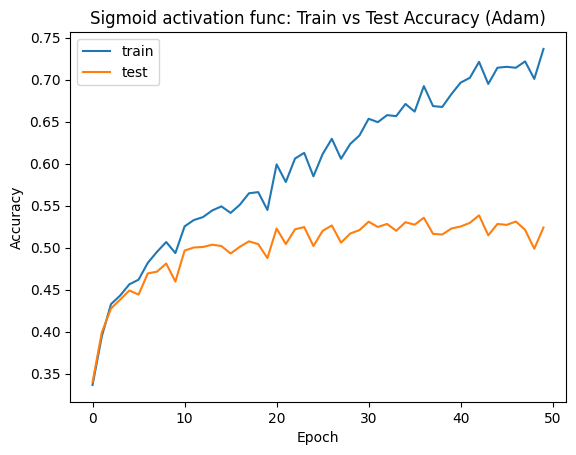

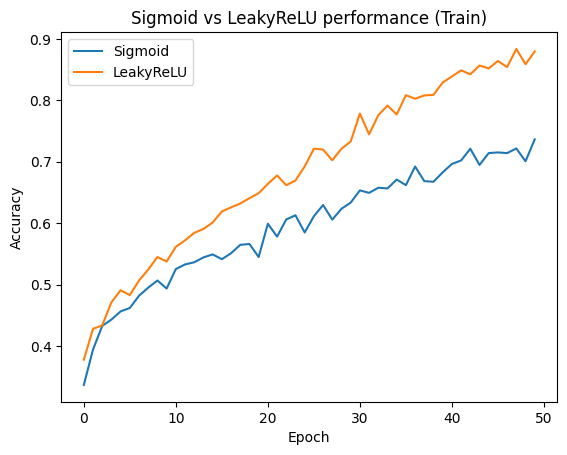

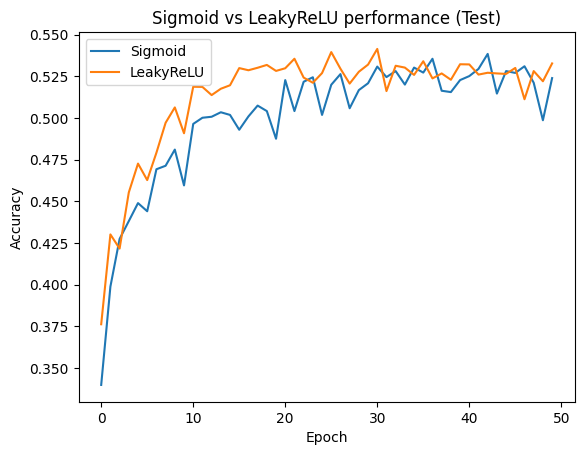

In [15]:

def plot_acc(title, first_metric, second_metric, label1, label2):
  x = np.arange(len(first_metric))

  plt.plot(x, first_metric, label=label1)
  plt.plot(x, second_metric, label=label2)
  plt.title(f'{title}')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

plot_acc('Sigmoid activation func: Train vs Test Accuracy (Adam)', sigmoid_adam_train_accuracies, sigmoid_adam_test_accuracies, 'train', 'test')
plot_acc('Sigmoid vs LeakyReLU performance (Train)', sigmoid_adam_train_accuracies, adam_train_accuracies, 'Sigmoid', 'LeakyReLU')
plot_acc('Sigmoid vs LeakyReLU performance (Test)', sigmoid_adam_test_accuracies, adam_test_accuracies, 'Sigmoid', 'LeakyReLU')

# 3. Dropout을 적용한 이후의 generalization error 확인

## [MY CODE] Dropout 적용한 모델 정의
- 활성화 함수: Leaky ReLU | 비용 함수: CrossEntropyLoss | Optimizer: Adam | Generalization: Dropout
- 각 레이어 사이에 Dropout 레이어를 추가(학습 중에 일부 뉴런을 확률적으로 비활성화)

In [24]:
class ModelLeakyReluDropOut(nn.Module):
    def __init__(self, input_dim, n_dim, dropout_prob):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)

        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.act(self.layer1(x)))  # activation 후에 Dropout 적용
        x = self.dropout(self.act(self.layer2(x)))
        x = self.layer3(x)  # digits 보장 위해서 Dropout 적용 X
        return x

## [MY CODE] Dropout 적용 모델 getter 함수 정의

In [25]:
def get_leaky_relu_drop_out_model(input_dim, n_dim, dropout_prob):
  model = ModelLeakyReluDropOut(input_dim, n_dim, dropout_prob).to('cuda')
  return model

## [MY CODE] Dropout 적용 모델 훈련 함수

In [26]:
def train_dropout_model(model, trainloader, testloader, optimizer, loss_function, n_epochs, checkpoint_path):
    train_accuracies = []
    test_accuracies = []
    start_epoch = 0

    # 체크포인트가 존재하면 불러오기
    try:
        start_epoch, train_accuracies, test_accuracies = load_checkpoint(checkpoint_path, model, optimizer)
    except (FileNotFoundError, KeyError, RuntimeError) as e:
        print(f"Checkpoint load failed: {e}. Starting from scratch.")

    # 학습 Loop
    for epoch in range(start_epoch, n_epochs):
        total_loss = 0.

        model.train() # 학습 모드 - Dropout이 활성화되어 지정된 확률로 뉴런을 비활성화
        for data in trainloader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = loss_function(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # 정확도 계산
        train_accuracy = accuracy(model, trainloader)
        test_accuracy = accuracy(model, testloader)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1:3d} | Loss: {total_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {test_accuracy:.4f}")

        # 매 epoch 마다 체크포인트 저장
        save_checkpoint(epoch, model, optimizer, train_accuracies, test_accuracies, checkpoint_path)

    return train_accuracies, test_accuracies


## [MY CODE] Dropout 적용 모델 훈련 실행

In [27]:
leaky_relu_model_3 = get_leaky_relu_drop_out_model(32 * 32 * 3, 1024, 0.1) # Dropout 적용 모델 인스턴스
adam_optimizer = get_optimizer_adam(leaky_relu_model_3, 0.001)
cross_entropy_loss = nn.CrossEntropyLoss()
dropout_checkpoint_path = './checkpoint_dropout.pth'

dropout_train_accuracies, dropout_test_accuracies = train_model(leaky_relu_model_3, trainloader, testloader, adam_optimizer, cross_entropy_loss, 50, dropout_checkpoint_path) # 학습 실행

<ipython-input-22-d3b0badec0bd>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


Checkpoint load failed: [Errno 2] No such file or directory: './checkpoint_dropout.pth'. Starting from scratch.
Epoch   1 | Loss: 371.6234 | Train Accuracy: 0.3809 | Test Accuracy: 0.3820
Checkpoint saved at ./checkpoint_dropout.pth
Epoch   2 | Loss: 331.9614 | Train Accuracy: 0.4314 | Test Accuracy: 0.4250
Checkpoint saved at ./checkpoint_dropout.pth
Epoch   3 | Loss: 316.5020 | Train Accuracy: 0.4535 | Test Accuracy: 0.4530
Checkpoint saved at ./checkpoint_dropout.pth
Epoch   4 | Loss: 304.0058 | Train Accuracy: 0.4620 | Test Accuracy: 0.4504
Checkpoint saved at ./checkpoint_dropout.pth
Epoch   5 | Loss: 296.0501 | Train Accuracy: 0.4793 | Test Accuracy: 0.4674
Checkpoint saved at ./checkpoint_dropout.pth
Epoch   6 | Loss: 289.4742 | Train Accuracy: 0.4908 | Test Accuracy: 0.4780
Checkpoint saved at ./checkpoint_dropout.pth
Epoch   7 | Loss: 284.4094 | Train Accuracy: 0.5022 | Test Accuracy: 0.4850
Checkpoint saved at ./checkpoint_dropout.pth
Epoch   8 | Loss: 279.9212 | Train Accura

## [MY CODE] 결과 모니터링
Trainset과 Testset의 정확도 차이 (Epoch 50 기준)
- Dropout 적용 전: 34.7%p
- Dropout 적용 후: 24.0%p


---


Dropout 적용 후에 간극이 10.7%p 만큼 감소하였습니다.<br>
여러번 테스트를 진행하진 못했지만, 이를 통해 Dropout이 Overfitting 개선에 효과가 있음을 확인하였습니다.

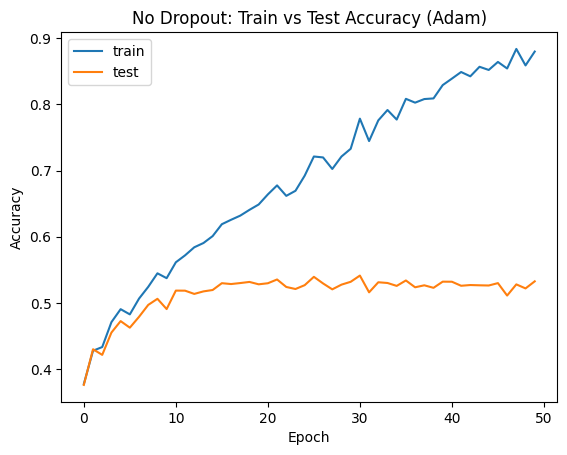

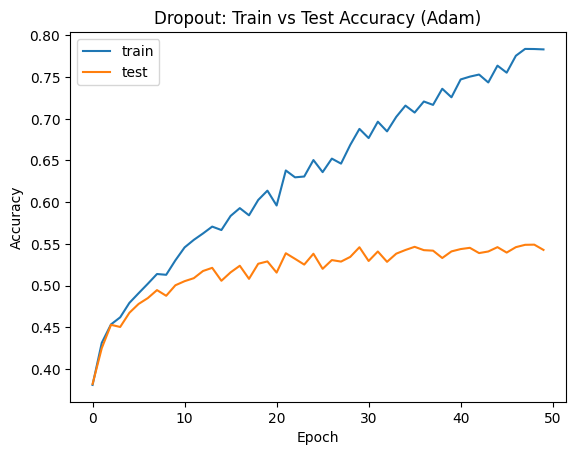

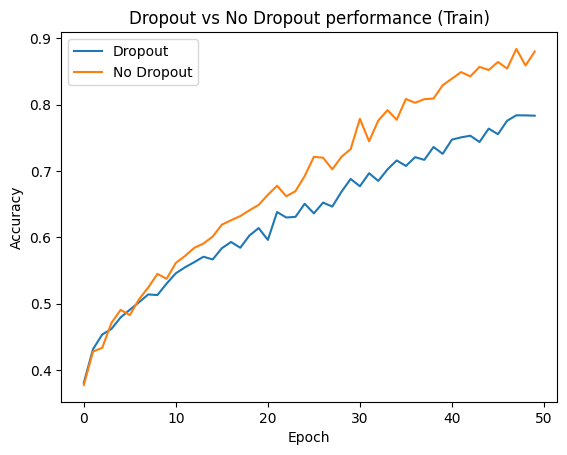

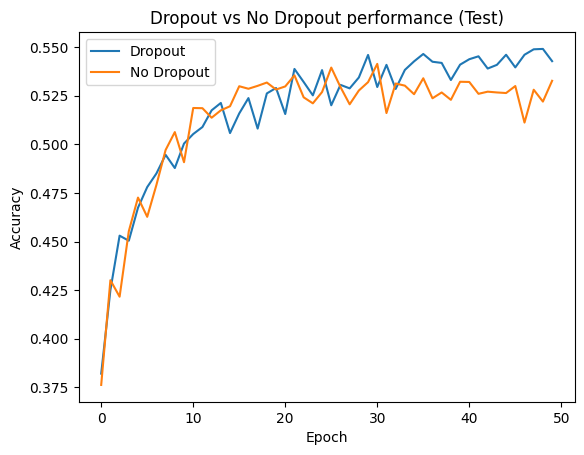

In [28]:
def plot_acc(title, first_metric, second_metric, label1, label2):
  x = np.arange(len(first_metric))

  plt.plot(x, first_metric, label=label1)
  plt.plot(x, second_metric, label=label2)
  plt.title(f'{title}')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

plot_acc('No Dropout: Train vs Test Accuracy (Adam)', adam_train_accuracies, adam_test_accuracies, 'train', 'test')
plot_acc('Dropout: Train vs Test Accuracy (Adam)', dropout_train_accuracies, dropout_test_accuracies, 'train', 'test')
plot_acc('Dropout vs No Dropout performance (Train)', dropout_train_accuracies, adam_train_accuracies, 'Dropout', 'No Dropout')
plot_acc('Dropout vs No Dropout performance (Test)', dropout_test_accuracies, adam_test_accuracies, 'Dropout', 'No Dropout')

# 4. Todo: 추가적으로 해볼 시도
- LeakyReLU 대신 GELU 적용
- Input 차원 조정 및 중간 레이어 추가
- Learing rate 조정
- Drop out 확률 조정
- Warm-up 도입 시도